# Advanced methods in Python
[Cycle plots](#Diurnal-and-Annual-Cycle-plots) | [Bar plots](#Bar-plots) | [Resampling](#Resampling) | [Filtering](#Filtering) | [Scatter plots](#Scatter-plots)

Now you should be familiar with the basics of how to access NetCDF files, inspect their contents, gather information on units, and plot one or more variables over specified date ranges. Now we will look at different ways of filtering and aggregating data.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps for plottting

%matplotlib inline

## Diurnal and Annual Cycle plots
[Cycle plots](#Diurnal-and-Annual-Cycle-plots) | [Bar plots](#Bar-plots) | [Resampling](#Resampling) | [Filtering](#Filtering) | [Scatter plots](#Scatter-plots)

If you are interested in exploring incoming and outgoing radiation, you will want to aggregate the data in different ways.

In [2]:
# open netcdf file
data_url = 'http://hydromet-thredds.princeton.edu:9000/thredds/dodsC/MonitoringStations/broadmead.nc'
ds = xr.open_dataset(data_url)

# select 4 components of radiation
radiation_ds = ds[['Rl_downwell_Avg', 'Rl_upwell_Avg', 'Rs_downwell_Avg', 'Rs_upwell_Avg']]

# convert to a pandas.dataframe object
radiation_df = radiation_ds.to_dataframe()

In Intro to Python we learned how to inspect data using boxplots:

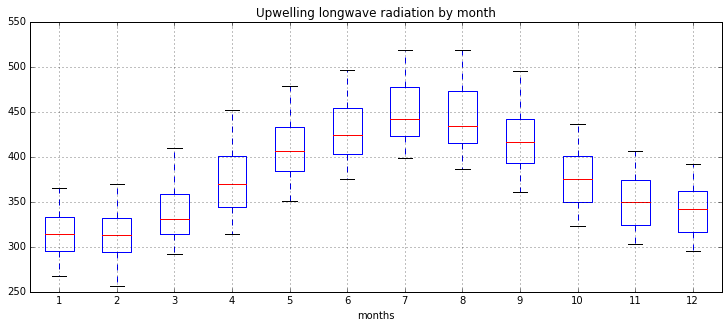

In [3]:
radiation_df.boxplot(column='Rl_upwell_Avg', by=radiation_df.index.month, 
                     whis= [5, 95], sym='', figsize=(12,5))
plt.xlabel('months')
plt.title('Upwelling longwave radiation by month')
plt.suptitle('')
plt.show()

Now we will look at this same data but plot all the daily mean for each of the years of record. 

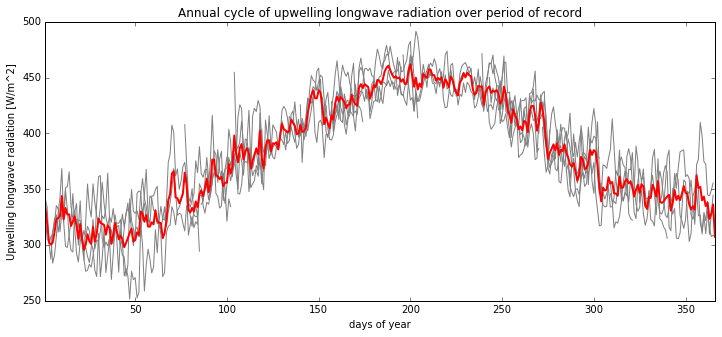

In [4]:
# pivot the data to make the index the day of year and the columns the years
pv = pd.pivot_table(radiation_df, 
                    index=radiation_df.index.dayofyear, 
                    columns=radiation_df.index.year, 
                    values='Rl_upwell_Avg', aggfunc='mean')

# plot the aggregated data, since we don't really care which year is which
# we can turn the legend off and set all the colors to gray
pv.plot(figsize=(12,5), legend=False, color='gray')

# plot the data that has been averaged across years
pv.mean(axis=1).plot(linewidth=2, color='red')
plt.ylabel('Upwelling longwave radiation [W/m^2]')
plt.xlabel('days of year')
plt.title('Annual cycle of upwelling longwave radiation over period of record')
plt.show()

You can see how this same general method can be used to look at the diurnal cycle. We can separate the data out by month so we can see how the diurnal cycle changes with season (this is the plot from the presentation)

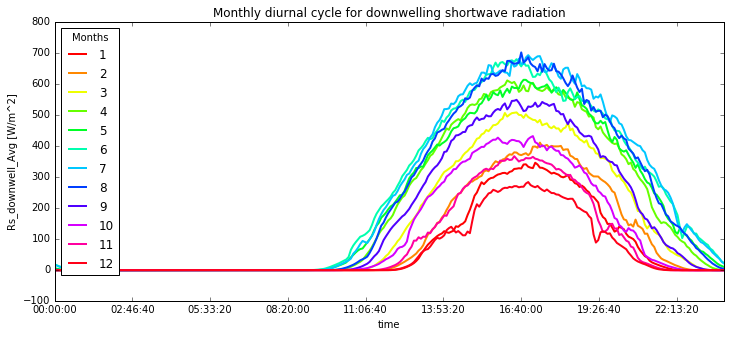

In [5]:
# by changing just these two variables, you can create a whole new presentation-quality plot
var = 'Rs_downwell_Avg'
title = 'Monthly diurnal cycle for downwelling shortwave radiation'

# pivot the data to make the index time of day and the columns the months
pv = pd.pivot_table(radiation_df,
                    index=radiation_df.index.time, 
                    columns=radiation_df.index.month, 
                    values=var)

# set the colors to a discretized circular colormap to fit cyclical data
pv.plot(figsize=(12,5), color=cm.hsv(np.linspace(0, 1, 12)), linewidth=2, title=title)
plt.legend(title='Months', loc='upper left')

# using this method we can create labels that depend only on var
plt.ylabel('{var} [{units}]'.format(var=var, units=ds[var].units))

plt.savefig(title+'.png')
plt.show()

Or maybe you want to look at all 4 of the radiation components' diurnal cycles. To do this we create a loop that goes through each component, creates a pivot table with index=time and columns=month, then take the mean across months and concatenates the dataframe with those already computed. This concatenated dataframe is what we ultimately plot.

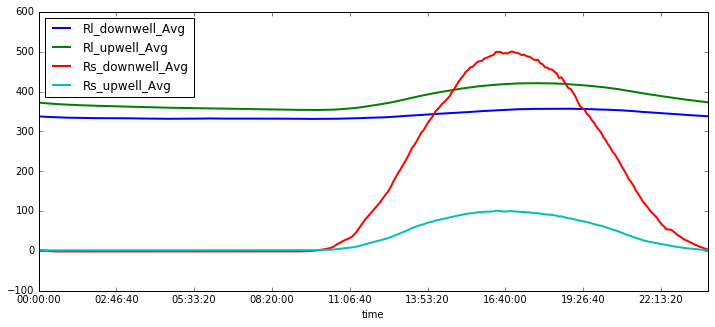

In [6]:
df = None
for v in ['Rl_downwell_Avg', 'Rl_upwell_Avg', 'Rs_downwell_Avg', 'Rs_upwell_Avg']:
    pv = pd.pivot_table(radiation_df, 
                        index=radiation_df.index.time, 
                        columns=radiation_df.index.month, 
                        values=v)
    df_rad = pd.DataFrame(pv.mean(axis=1), columns=[v])
    df = pd.concat([df, df_rad], axis=1)
df.plot(figsize=(12,5), linewidth=2)
plt.show()

## Bar plots
[Cycle plots](#Diurnal-and-Annual-Cycle-plots) | [Bar plots](#Bar-plots) | [Resampling](#Resampling) | [Filtering](#Filtering) | [Scatter plots](#Scatter-plots)

Calculate monthly accumulated rainfall across the period of record. Be careful when summing across period of record that the data is comprehensive enough to justify that type of action. You shouldn't do this for Broadmead because the there are lots of months of incomplete data.

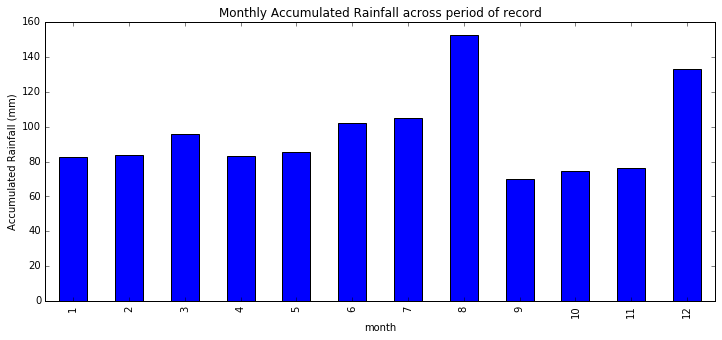

In [7]:
data_url = 'http://hydromet-thredds.princeton.edu:9000/thredds/dodsC/MonitoringStations/butler.nc'
ds = xr.open_dataset(data_url)

# convert to a pandas.dataframe object
df = ds['Rain_mm_3_Tot'].to_dataframe()

# pivot the data to make the index the accumulated rainfall and the columns the years. 
pv = pd.pivot_table(df, index=df.index.month, columns=df.index.year, values='Rain_mm_3_Tot', aggfunc='sum')

# take the mean across the columns (years) and then plot it as a bar graph
pv.mean(axis=1).plot.bar(figsize=(12,5))
plt.ylabel('Accumulated Rainfall (mm)')
plt.xlabel('month')
plt.title('Monthly Accumulated Rainfall across period of record')
plt.show()

## Resampling
[Cycle plots](#Diurnal-and-Annual-Cycle-plots) | [Bar plots](#Bar-plots) | [Resampling](#Resampling) | [Filtering](#Filtering) | [Scatter plots](#Scatter-plots)

Say we want to find the rainiest days on the green roof. To do this we need to calculate the total rainfall for each day on record. 

In [8]:
data_url = 'http://hydromet-thredds.princeton.edu:9000/thredds/dodsC/MonitoringStations/butler.nc'
ds = xr.open_dataset(data_url)

# resample to a daily time scale by summing across time (other units are 'min', 'H')
ds_rain = ds['Rain_mm_3_Tot'].resample('1D','time', how='sum', label='right')

# convert to a pandas.Series object and then sort so that the largest values are at the top
wettest = ds_rain.to_pandas().sort_values(ascending=False)

# print the top 5 values
wettest.head(5)

time
2011-08-29    187.442
2011-08-15    133.860
2014-05-01     70.614
2013-11-28     70.360
2011-07-04     65.534
dtype: float64

## Filtering
[Cycle plots](#Diurnal-and-Annual-Cycle-plots) | [Bar plots](#Bar-plots) | [Resampling](#Resampling) | [Filtering](#Filtering) | [Scatter plots](#Scatter-plots)

If we are only interested in times when there is rainfall and the soil moisture is above a certain threshold, we can filter the dataset before we load it all into memory.

In [9]:
data_url = 'http://hydromet-thredds.princeton.edu:9000/thredds/dodsC/MonitoringStations/butler.nc'
ds = xr.open_dataset(data_url)

# use the where command to filter data as it comes in and drop all the times at which the criteria aren't met
rain_on_wet_soil = ds.where((ds['Rain_mm_3_Tot']>0) & (ds['VW']>.30)).dropna('time')

# check out what these times look like
rain_on_wet_soil.to_dataframe()[['Rain_mm_3_Tot', 'VW']].describe()

,Rain_mm_3_Tot,VW
count,710.000000,710.000000
mean,1.864234,0.313446
std,2.624727,0.009520
min,0.254000,0.301000
25%,0.254000,0.305000
50%,1.016000,0.312000
75%,2.286000,0.321000
max,34.290000,0.347000


## Scatter plots
[Cycle plots](#Diurnal-and-Annual-Cycle-plots) | [Bar plots](#Bar-plots) | [Resampling](#Resampling) | [Filtering](#Filtering) | [Scatter plots](#Scatter-plots)

One classic use of scatter plots would be to compare the methods of measuring rainfall. The Parsivel Disdrometer records rain intensity (mm/hr) every 30 seconds by counting an measuring drops passing through its laser beam. Tipping bucket gages on the other hand accumulate rain over the period of collection and when the bucket reaches a certain level (in this case 0.01 inches) the bucket tips and empties. The recorded data is essentially tips per frequency of observation. 

In order to compare these dataset we will need to resample the disdrometer data to match the time step of the tipping bucket gages. We will also need to go from rate (mm/hr) to accumulation (mm) so we will by 60. 

In [10]:
data_url = 'http://hydromet-thredds.princeton.edu:9000/thredds/dodsC/MonitoringStations/broadmead_parsivel.nc'
ds = xr.open_dataset(data_url)['rain_intensity']

# resample to match time step and divide by 60 to convert from rate to accumulation/
df_parsivel = ds.to_pandas().resample('1min', label='right').mean()/60
df_parsivel.name = 'parsivel'

data_url = 'http://hydromet-thredds.princeton.edu:9000/thredds/dodsC/MonitoringStations/broadmead_1min.nc'
ds= xr.open_dataset(data_url)[['Rain_1_mm_Tot', 'Rain_2_mm_Tot']]
df_tipping = ds.to_dataframe()[['Rain_1_mm_Tot', 'Rain_2_mm_Tot']]

# join the datasets and only keep the time steps when data is availble for every variable (how='inner')
df = df_tipping.join(df_parsivel, how='inner')

# change the names of the columns to something more descriptive
df.columns = ['tipping_1', 'tipping_2', 'parsivel_1min']

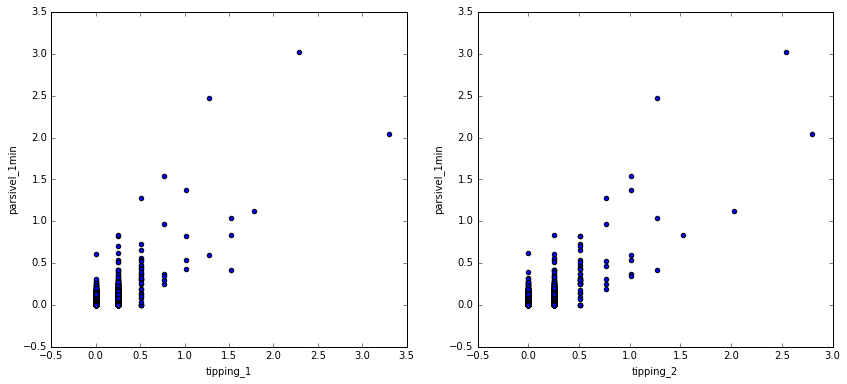

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14,6))
df.plot.scatter('tipping_1', 'parsivel_1min', ax=axes[0])
df.plot.scatter('tipping_2', 'parsivel_1min', ax=axes[1])
plt.show()

At the one minute frequency it is hard to see anything other than the tips. To get away from the limitations of the minimum sample size, we can resample again to get hourly accumulation and then we can compare these.

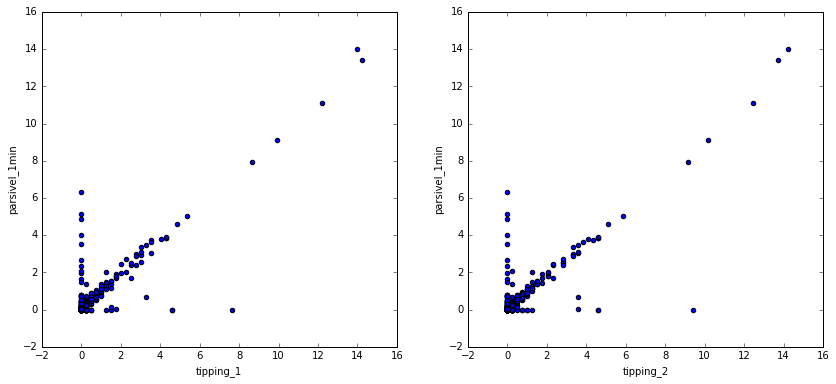

In [12]:
df_hourly = df.resample('1H', label='right').sum()
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(14,6))
df_hourly.plot.scatter('tipping_1', 'parsivel_1min', ax=axes[0])
df_hourly.plot.scatter('tipping_2', 'parsivel_1min', ax=axes[1])
plt.show()